In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from glob import glob
from collections import Counter

import keras_tuner as kt


In [3]:
bs = 8 # Increase Batch size based on your hardware capacity, if you have powerful GPU try BS=128,256...
train_dir = r'../input/bird-species-classification-220-categories/Train'
test_dir = r'../input/bird-species-classification-220-categories/Test'

In [4]:
train = glob(r'../input/bird-species-classification-220-categories/Train/*/*')
labels_train = [el.split('/')[4] for el in train ]

## Visualisation 

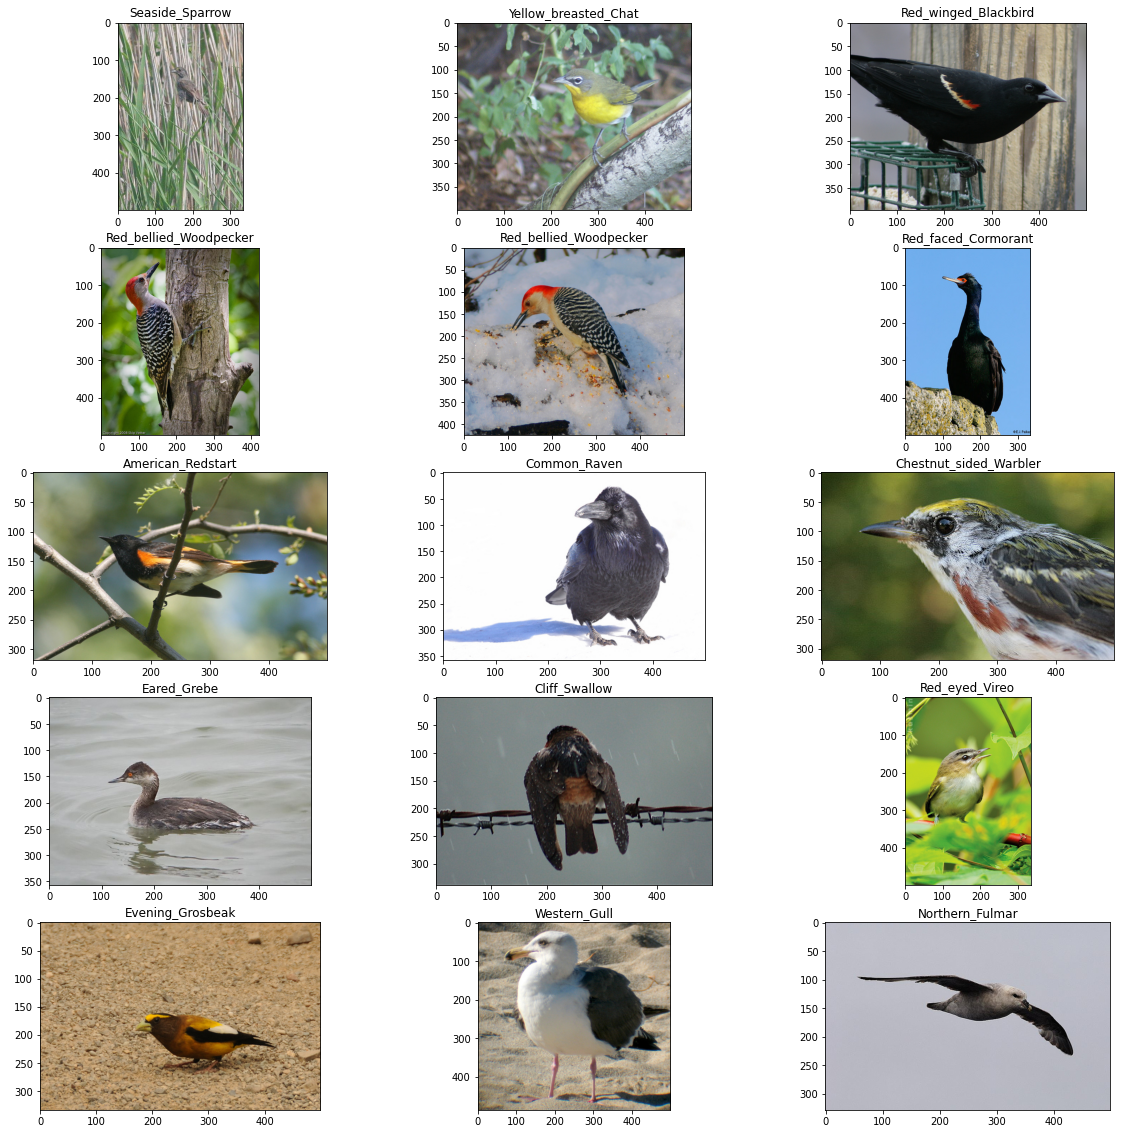

In [5]:
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
fig.subplots_adjust()
im_list = np.random.choice(train, 15)
for axi, im in zip( ax.flat, im_list):
    axi.set_title(im.split('/')[4],)
    axi.imshow(plt.imread(im), )

In [6]:
distribution_dict = {k:np.round(v*100/len(labels_train), 2) for k,v in Counter(labels_train).items()} 

data = pd.DataFrame(distribution_dict.values(), distribution_dict.keys())
print('Median % - ',  data[0].median(), 
       '\nMax % - ', data[0].max(), 
       '\nMin % - ', data[0].min(),)

Median % -  0.51 
Max % -  0.51 
Min % -  0.34


## Generation of new img

In [7]:
train_gen = ImageDataGenerator(rescale=1./255, rotation_range = 20,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                vertical_flip = True)

test_gen = ImageDataGenerator(rescale=1./255)



In [8]:
n_dim = 200
data_pd = pd.DataFrame(zip(train, labels_train), columns=['X', 'y'])
sample_data = data_pd.sample(frac=0.2)
train_data = train_gen.flow_from_dataframe(sample_data,x_col='X', y_col='y', batch_size=bs, target_size = (n_dim, n_dim), class_mode = "categorical", shuffle=True)
test_data = test_gen.flow_from_directory(test_dir, batch_size=bs, target_size = (n_dim, n_dim), class_mode = "categorical")

Found 1883 validated image filenames belonging to 200 classes.
Found 2374 images belonging to 200 classes.


In [28]:
def build_model(hp, num_classes=200, shape=(n_dim,n_dim,3)):
    inputs = tf.keras.layers.Input(shape=shape)
    

    efb1 = EfficientNetB1(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None)
    
    efb3 = EfficientNetB3(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)
    
    efb5 = EfficientNetB5(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)
    
    efb7 = EfficientNetB7(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None,)
    
    
    hp_model = hp.Choice('model', values=['efb1', 'efb3', 'efb5','efb7'])
    
    if hp_model == 'efb1':
        model = efb1
    elif hp_model == 'efb3':
        model = efb3
    elif hp_model == 'efb5':
        model = efb5       
    elif hp_model == 'efb7':
        model = efb7
    else:
        raise

    
    model.trainable = True
    
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    top_dropout_rate = 0.33
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    

    
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
    

    
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    return model

In [10]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5, seed=123,)

258088960/258076736 [==============================] - 10s 0us/step


In [11]:
tuner.search(train_data, epochs=10, validation_data=test_data)

Trial 4 Complete [00h 24m 09s]
val_loss: 2.5778729915618896

Best val_loss So Far: 2.5778729915618896
Total elapsed time: 00h 55m 18s


In [12]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'model': 'efb7'}

In [13]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
model: efb7
Score: 2.5778729915618896
Trial summary
Hyperparameters:
model: efb5
Score: 2.8647513389587402
Trial summary
Hyperparameters:
model: efb3
Score: 3.3651375770568848
Trial summary
Hyperparameters:
model: efb1
Score: 3.730807304382324


In [14]:
pip freeze 

absl-py @ file:///home/conda/feedstock_root/build_artifacts/absl-py_1637088766493/work
accelerate==0.10.0
access==1.1.8
affine==2.3.1
aiobotocore==2.3.4
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1649013150570/work
aioitertools==0.10.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1636093929600/work
albumentations==1.2.0
alembic==1.8.0
allennlp==2.9.3
altair==4.2.0
annoy==1.17.0
ansiwrap==0.8.4
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1652463872367/work/dist
apache-beam==2.39.0
aplus==0.11.0
appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1649500320262/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1643313750486/work
arviz==0.12.1
asn1crypto @ file:///home/conda/feeds